# DATA PREPROCESSING

In this notebook we will do exploratory examinations of our data. 

The data will then be preprocessed with additional Technical Analysis features added.

In [3]:
import numpy as np
import pandas as pd
import talib
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import os
from pathlib import Path


# increase size of plots:
default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = default_dpi*2

# import data and inspect head:
data = pd.read_csv("../data/raw/BtrexCSVs/BTC_NEO.csv")
data.head(5)


,DateTime,Open,Close,Low,High,Volume,BaseVolume
0,2017-11-22 01:10:00,0.004316,0.004305,0.004305,0.004319,2004.199567,8.644211
1,2017-11-22 01:15:00,0.004305,0.004288,0.004282,0.004306,1011.973133,4.345338
2,2017-11-22 01:20:00,0.004288,0.004288,0.004282,0.004297,1990.877709,8.538191
3,2017-11-22 01:25:00,0.004288,0.004303,0.004288,0.004310,2116.678468,9.097914
4,2017-11-22 01:30:00,0.004303,0.004285,0.004283,0.004303,1343.086967,5.766947


### Sort Markets by avg. trading volume and select top volume markets:

In [2]:

# check avg trading volumes and list in order.
# i would like to train using groups of coins with similar vols

AvgsList = []

pathlist = Path('../data/raw/BtrexCSVs').glob('**/*.csv')
for path in pathlist:
    pathStr = str(path)
    pairStr = pathStr.split('\\')[-1].split('.')[0]
    
    checkData = pd.read_csv(pathStr)        
    volAvg = np.mean(checkData[['BaseVolume']].values)
    
    AvgsList.append((pairStr, volAvg))
    
    
#sort list in descending order by average volume:    
def getKey(item):
    return item[1]
AvgsList.sort(key=getKey, reverse=True)

for p in AvgsList:
    print('{} => {}, {}'.format((AvgsList.index(p) + 1), p[0], p[1]))

1 => BTC_XRP, 11.617822246798347
2 => BTC_BCC, 10.574166895213835
3 => BTC_ETH, 9.629718569835545
4 => BTC_ADA, 9.346570030257727
5 => BTC_XVG, 9.265953181387049
6 => BTC_NXT, 6.101462051674242
7 => BTC_XLM, 5.824089697337426
8 => BTC_TRX, 4.9913756305005
9 => BTC_SC, 4.600460500201872
10 => BTC_LTC, 4.3256440248576045
11 => BTC_NEO, 4.244787928606024
12 => BTC_ETC, 3.372319556966961
13 => BTC_EMC2, 3.349368583881783
14 => BTC_RDD, 2.9837565992032307
15 => BTC_BTG, 2.8583729382032046
16 => BTC_VOX, 2.80459964355069
17 => BTC_XEM, 2.7090355827489323
18 => BTC_QTUM, 2.689735844007354
19 => BTC_ZCL, 2.688704806379101
20 => BTC_STRAT, 2.451046671752708
21 => BTC_OMG, 2.2497398338540693
22 => BTC_SRN, 2.238408840410871
23 => BTC_DGB, 2.227551010675066
24 => BTC_NBT, 2.219833980466844
25 => BTC_POWR, 2.147125164978473
26 => BTC_TRIG, 2.1425819405426565
27 => BTC_LSK, 2.1339024277043452
28 => BTC_SNT, 1.8057127117010008
29 => BTC_MTL, 1.7992804014925372
30 => BTC_RISE, 1.7347146568083964
31 =

In [102]:
# i have assigned training groups in distinct groups according to avg volume level:

VHighVol_Pairs = ['BTC_XRP', 'BTC_BCC', 'BTC_ETH', 'BTC_ADA', 'BTC_XVG']
HighVol_Pairs = ['BTC_NXT', 'BTC_XLM', 'BTC_SC', 'BTC_LTC', 'BTC_NEO']
MedVol_Pairs = ['BTC_ETC', 'BTC_EMC2', 'BTC_RDD', 'BTC_BTG', 'BTC_VOX', 'BTC_XEM', 'BTC_QTUM', 
                'BTC_ZCL', 'BTC_STRAT', 'BTC_OMG', 'BTC_LSK', 'BTC_SNT', 'BTC_MTL', 'BTC_RISE', 
                'BTC_MCO', 'BTC_DOGE', 'BTC_XMR', 'BTC_FUN', 'BTC_DASH', 'BTC_WAVES', 'BTC_ZEC', 
                'BTC_RCN', 'BTC_SYS', 'BTC_STEEM', 'BTC_VTC', 'BTC_BAY', 'BTC_XDN', 'BTC_HMQ', 
                'BTC_PAY', 'BTC_GNT']
LowVol_Pairs = [x[0] for x in AvgsList[47:]]


## Smooth timegaps using LOCF, and extract longest consecutive sequence of datapoints 
## (from each market)

In [30]:
def getMaxSmoothSequence(pairs, minSeqLen, readDir, writeDir):    
    if not os.path.exists(writeDir): os.makedirs(writeDir)
    dateFormat = "%Y-%m-%d %H:%M:%S"
    removePairs = []
    # data may contain line gaps for periods with no trades.
    # use 'Last Observation Carried Forward' to fill 1 candle gaps:
    for pair in pairs:
        print('Smoothing {}...'.format(pair))    
        data = pd.read_csv("{}{}.csv".format(readDir, pair))    

        smoothDat = pd.DataFrame(columns=data.columns)

        #drop 'Volume' column and rename 'BaseVolume' to 'Volume':
        data = data.drop('Volume', axis=1)
        data = data.rename(columns={'BaseVolume': 'Volume'})    

        smoothedData = pd.DataFrame(columns=data.columns)

        prevDateTime = datetime.datetime.strptime('2017-11-22 01:10:00', dateFormat)
        prevClose = 0.

        for row in data.itertuples():
            timestamp = datetime.datetime.strptime(row.DateTime, dateFormat)
            timeDiff = (timestamp - prevDateTime).seconds

            if timeDiff == 300: #seconds == 5 minutes
                # add row to smoothedData:
                newRow = pd.DataFrame([list(row)[1:]], columns=data.columns)
                smoothedData = smoothedData.append(newRow, ignore_index=True)

            elif timeDiff == 600: #seconds == 10 minute gap == 1 missing 5m candle
                # enter 1 LOCF row, add next row:
                nextDateTime = timestamp + datetime.timedelta(minutes=5)
                LOCFdatetime = datetime.datetime.strftime(nextDateTime, dateFormat)
                LOCFrow = pd.DataFrame([[LOCFdatetime, prevClose, prevClose, prevClose, prevClose, 0.]], columns=smoothedData.columns)            
                newRow = pd.DataFrame([list(row)[1:]], columns=data.columns)
                smoothedData = pd.concat([smoothedData, LOCFrow, newRow], ignore_index=True)            

            elif timeDiff > 600: #seconds == larger time gap                
                if len(smoothedData) > len(smoothDat):
                    smoothDat = smoothedData            
                smoothedData = pd.DataFrame(columns=data.columns) 

            prevDateTime = timestamp
            prevClose = row.Close

        # add final sequence 
        if len(smoothedData) > len(smoothDat):
                smoothDat = smoothedData
        smoothedData = pd.DataFrame(columns=data.columns)

        if len(smoothDat) > minSeqLen:
            savefile = "{}{}.csv".format(writeDir, pair)
            smoothDat.to_csv(savefile, index=False)
            print('    >>>Smoothed sequence of length: {} SAVED to [{}]'.format(len(smoothDat), savefile))
        else:
            removePairs.append(pair)
            print('    >>>MIN_SEQ_LENGTH REQUIREMENT NOT MET')
            
    return removePairs


In [62]:
min_seqLength = 10000
loadPath = '../data/raw/BtrexCSVs/'

print('[SMOOTHING VERY HIGH VOLUME PAIRS]')
savePath = '../data/smoothed/VHighVolume/'
getMaxSmoothSequence(VHighVol_Pairs, min_seqLength, loadPath, savePath)

[SMOOTHING VERY HIGH VOLUME PAIRS]
Smoothing BTC_XRP...
    >>>Smoothed sequence of length: 27801 SAVED to [data/smoothed/VHighVolume/BTC_XRP.csv]
Smoothing BTC_BCC...
    >>>Smoothed sequence of length: 27797 SAVED to [data/smoothed/VHighVolume/BTC_BCC.csv]
Smoothing BTC_ETH...
    >>>Smoothed sequence of length: 27801 SAVED to [data/smoothed/VHighVolume/BTC_ETH.csv]
Smoothing BTC_ADA...
    >>>Smoothed sequence of length: 14481 SAVED to [data/smoothed/VHighVolume/BTC_ADA.csv]
Smoothing BTC_XVG...
    >>>Smoothed sequence of length: 13436 SAVED to [data/smoothed/VHighVolume/BTC_XVG.csv]


In [63]:
print('[SMOOTHING HIGH VOLUME PAIRS]')
loadPath = '../data/raw/BtrexCSVs/'
savePath = '../data/smoothed/HighVolume/'
getMaxSmoothSequence(HighVol_Pairs, min_seqLength, loadPath, savePath)

[SMOOTHING HIGH VOLUME PAIRS]
Smoothing BTC_NXT...
    >>>Smoothed sequence of length: 11085 SAVED to [data/smoothed/HighVolume/BTC_NXT.csv]
Smoothing BTC_XLM...
    >>>Smoothed sequence of length: 27801 SAVED to [data/smoothed/HighVolume/BTC_XLM.csv]
Smoothing BTC_TRX...
    >>>MIN_SEQ_LENGTH REQUIREMENT NOT MET
Smoothing BTC_SC...
    >>>Smoothed sequence of length: 23791 SAVED to [data/smoothed/HighVolume/BTC_SC.csv]
Smoothing BTC_LTC...
    >>>Smoothed sequence of length: 27803 SAVED to [data/smoothed/HighVolume/BTC_LTC.csv]
Smoothing BTC_NEO...
    >>>Smoothed sequence of length: 27798 SAVED to [data/smoothed/HighVolume/BTC_NEO.csv]


In [87]:
print('[SMOOTHING MEDIUM VOLUME PAIRS]')
loadPath = '../data/raw/BtrexCSVs/'
savePath = '../data/smoothed/MedVolume/'
getMaxSmoothSequence(MedVol_Pairs, min_seqLength, loadPath, savePath)

[SMOOTHING MEDIUM VOLUME PAIRS]
Smoothing BTC_ETC...
    >>>Smoothed sequence of length: 27799 SAVED to [data/smoothed/MedVolume/BTC_ETC.csv]
Smoothing BTC_EMC2...
    >>>Smoothed sequence of length: 16527 SAVED to [data/smoothed/MedVolume/BTC_EMC2.csv]
Smoothing BTC_RDD...
    >>>Smoothed sequence of length: 23792 SAVED to [data/smoothed/MedVolume/BTC_RDD.csv]
Smoothing BTC_BTG...
    >>>Smoothed sequence of length: 26160 SAVED to [data/smoothed/MedVolume/BTC_BTG.csv]
Smoothing BTC_VOX...
    >>>Smoothed sequence of length: 15684 SAVED to [data/smoothed/MedVolume/BTC_VOX.csv]
Smoothing BTC_XEM...
    >>>Smoothed sequence of length: 21253 SAVED to [data/smoothed/MedVolume/BTC_XEM.csv]
Smoothing BTC_QTUM...
    >>>Smoothed sequence of length: 19059 SAVED to [data/smoothed/MedVolume/BTC_QTUM.csv]
Smoothing BTC_ZCL...
    >>>Smoothed sequence of length: 19444 SAVED to [data/smoothed/MedVolume/BTC_ZCL.csv]
Smoothing BTC_STRAT...
    >>>Smoothed sequence of length: 25278 SAVED to [data/smoo

## Exploratory Plots of Closing prices

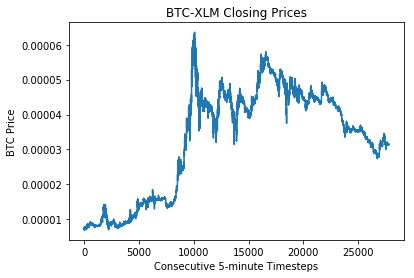

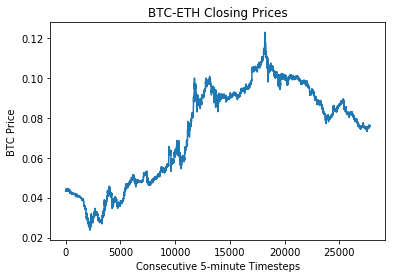

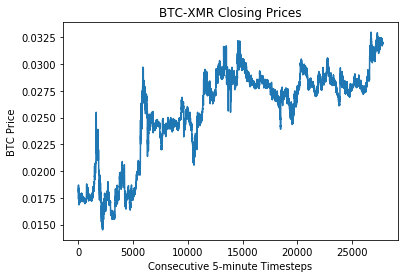

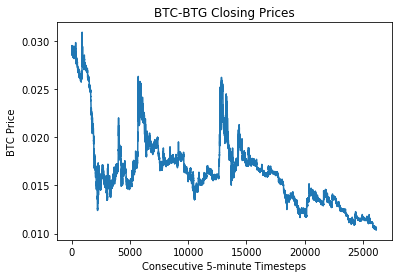

In [9]:
# plot closes for exploratory visualization
plotData = pd.read_csv("../data/smoothed/HighVolume/BTC_XLM.csv")

plt.plot(plotData['Close'])
plt.title('BTC-XLM Closing Prices')
plt.ylabel('BTC Price')
plt.xlabel('Consecutive 5-minute Timesteps')
plt.show()

plotData = pd.read_csv("../data/smoothed/VHighVolume/BTC_ETH.csv")

plt.plot(plotData['Close'])
plt.title('BTC-ETH Closing Prices')
plt.ylabel('BTC Price')
plt.xlabel('Consecutive 5-minute Timesteps')
plt.show()

plotData = pd.read_csv("../data/smoothed/MedVolume/BTC_XMR.csv")

plt.plot(plotData['Close'])
plt.title('BTC-XMR Closing Prices')
plt.ylabel('BTC Price')
plt.xlabel('Consecutive 5-minute Timesteps')
plt.show()

plotData = pd.read_csv("../data/smoothed/MedVolume/BTC_BTG.csv")

plt.plot(plotData['Close'])
plt.title('BTC-BTG Closing Prices')
plt.ylabel('BTC Price')
plt.xlabel('Consecutive 5-minute Timesteps')
plt.show()


## Calculate TA features and add new columns for each market

In [8]:
def SaveWithIndicatorsAdded(pairs, readDir, writeDir):        
    if not os.path.exists(writeDir): os.makedirs(writeDir)
    dateFormat = "%Y-%m-%d %H:%M:%S"

    # add new column containing each indicator data calulated from candle data 
    for pair in pairs:
        print('Adding TA indicator columns to {} data...'.format(pair))    
        data = pd.read_csv("{}{}.csv".format(readDir, pair))    
        
        highs = data[['High']]
        lows= data[['Low']]
        closes = data[['Close']]        
        highs = highs.values.flatten()                
        lows = lows.values.flatten()
        closes = closes.values.flatten()
        
        # Exponential Moving Avg (20 periods)
        ema20 = talib.EMA(closes, timeperiod=20)
        data = data.assign(EMA_20=ema20)
        
        # Percent change between EMA 12 and 26 periods
        ema12 = talib.EMA(closes, timeperiod=12)
        ema26 = talib.EMA(closes, timeperiod=26)
        ema_diff = ema12 / ema26
        data = data.assign(EMA_12_26_PDIFF=ema_diff)
        
        # Commodity Channel Index (14 periods)
        cci = talib.CCI(highs, lows, closes, timeperiod=14)
        data = data.assign(CCI=cci)
        
        # Moving Avg Convergence Divergence
        macd, macd_sig, macd_hist = talib.MACD(closes, fastperiod=12, slowperiod=26, signalperiod=9)        
        data = data.assign(MACD=macd, MACD_SIG=macd_sig, MACD_HIST=macd_hist)
        
        # Avg True Range
        atr = talib.ATR(highs, lows, closes, timeperiod=14)
        data = data.assign(ATR=atr)
        
        #Bollinger Bands
        upperband, middleband, lowerband = talib.BBANDS(closes, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
        data = data.assign(BOLBAND_UP=upperband, BOLBAND_MID=middleband, BOLBAND_LOW=lowerband)
        
        # Momentum (20 periods)
        mom20 = talib.MOM(closes, timeperiod=20)
        data = data.assign(MOM20=mom20)        
        
        # Rate of Change (10 periods)
        roc10 = talib.ROCP(closes, timeperiod=10)
        data = data.assign(ROC10=roc10)
        
        # drop rows with nan entries at beginning of data, then save:
        data.dropna(inplace=True)        
        savefile = "{}{}.csv".format(writeDir, pair)
        data.to_csv(savefile, index=False)
        print('    >>>Data with TA indicator columns added SAVED to [{}]'.format(savefile)) 

In [103]:
loadPath = '../data/smoothed/VHighVolume/'
savePath = '../data/IndicatorsAdded/VHighVolume/'
SaveWithIndicatorsAdded(VHighVol_Pairs, loadPath, savePath)

loadPath = '../data/smoothed/HighVolume/'
savePath = '../data/IndicatorsAdded/HighVolume/'
SaveWithIndicatorsAdded(HighVol_Pairs, loadPath, savePath)

loadPath = '../data/smoothed/MedVolume/'
savePath = '../data/IndicatorsAdded/MedVolume/'
SaveWithIndicatorsAdded(MedVol_Pairs, loadPath, savePath)

Adding TA indicator columns to BTC_XRP data...
    >>>Data with TA indicator columns added SAVED to [data/IndicatorsAdded/VHighVolume/BTC_XRP.csv]
Adding TA indicator columns to BTC_BCC data...
    >>>Data with TA indicator columns added SAVED to [data/IndicatorsAdded/VHighVolume/BTC_BCC.csv]
Adding TA indicator columns to BTC_ETH data...
    >>>Data with TA indicator columns added SAVED to [data/IndicatorsAdded/VHighVolume/BTC_ETH.csv]
Adding TA indicator columns to BTC_ADA data...
    >>>Data with TA indicator columns added SAVED to [data/IndicatorsAdded/VHighVolume/BTC_ADA.csv]
Adding TA indicator columns to BTC_XVG data...
    >>>Data with TA indicator columns added SAVED to [data/IndicatorsAdded/VHighVolume/BTC_XVG.csv]
Adding TA indicator columns to BTC_NXT data...
    >>>Data with TA indicator columns added SAVED to [data/IndicatorsAdded/HighVolume/BTC_NXT.csv]
Adding TA indicator columns to BTC_XLM data...
    >>>Data with TA indicator columns added SAVED to [data/IndicatorsAdd

## Processed Data Preview

In [4]:
savePath = '../data/IndicatorsAdded/MedVolume/'
data = pd.read_csv("{}{}.csv".format(savePath, 'BTC_ZEC')) 
data.head(20)

,DateTime,Open,Close,Low,High,Volume,EMA_20,EMA_12_26_PDIFF,CCI,MACD,MACD_SIG,MACD_HIST,ATR,BOLBAND_UP,BOLBAND_MID,BOLBAND_LOW,MOM20,ROC10
0,2017-11-30 11:50:00,0.031030,0.031000,0.030700,0.031360,4.830614,0.031028,1.000167,-14.999413,0.000013,3.413286e-05,-2.102981e-05,0.000331,0.031042,0.031015,0.030989,-0.000200,0.000000
1,2017-11-30 11:55:00,0.031000,0.031390,0.030950,0.031390,0.758724,0.031063,1.001082,142.202345,0.000040,3.536495e-05,4.928342e-06,0.000338,0.031391,0.031093,0.030795,0.000190,0.012581
2,2017-11-30 12:00:00,0.031300,0.031425,0.031300,0.031425,2.592691,0.031097,1.001873,204.014250,0.000064,4.107138e-05,2.282573e-05,0.000323,0.031556,0.031175,0.030794,0.000338,0.017705
3,2017-11-30 12:05:00,0.031425,0.031302,0.030700,0.031566,10.781046,0.031117,1.002158,92.422913,0.000072,4.724099e-05,2.467842e-05,0.000362,0.031589,0.031229,0.030870,0.000262,0.010421
4,2017-11-30 12:10:00,0.031445,0.031331,0.031000,0.031445,2.905083,0.031137,1.002430,109.696875,0.000080,5.372531e-05,2.593727e-05,0.000368,0.031592,0.031290,0.030988,0.000431,0.013949
5,2017-11-30 12:15:00,0.031331,0.031000,0.030700,0.031415,4.847095,0.031124,1.001768,-15.419271,0.000058,5.466328e-05,3.751892e-06,0.000393,0.031592,0.031290,0.030988,-0.000075,-0.003215
6,2017-11-30 12:20:00,0.030827,0.031182,0.030827,0.031298,1.499328,0.031130,1.001695,16.492722,0.000056,5.485932e-05,7.841759e-07,0.000398,0.031540,0.031248,0.030956,-0.000067,0.005880
7,2017-11-30 12:25:00,0.031000,0.030877,0.030877,0.031140,0.255414,0.031106,1.000836,-59.708736,0.000028,4.957936e-05,-2.111986e-05,0.000392,0.031489,0.031138,0.030788,-0.000222,-0.004506
8,2017-11-30 12:30:00,0.030870,0.030868,0.030700,0.031000,2.751430,0.031083,1.000130,-118.208464,0.000006,4.088685e-05,-3.477002e-05,0.000385,0.031412,0.031052,0.030691,-0.000517,-0.005220
9,2017-11-30 12:35:00,0.030700,0.030700,0.030700,0.030870,1.231294,0.031046,0.999144,-150.819660,-0.000025,2.774380e-05,-5.257222e-05,0.000370,0.031245,0.030925,0.030605,-0.000679,-0.010621


## Preprocess TEST DATA

In [31]:
def TrimCurrentData():    
    print('[TRIMMING TEST DATA]')
    AvgsList = []

    pathlist = Path('../data/raw/TestData').glob('*.csv')
    for path in pathlist:
        pathStr = str(path)
        pairStr = pathStr.split('\\')[-1].split('.')[0]
        checkData = pd.read_csv(pathStr)        
       
        dateFormat = "%Y-%m-%d %H:%M:%S"
        currDateTime = datetime.datetime.strptime('2018-09-19 20:50:00', dateFormat)
        currData = pd.DataFrame(columns=checkData.columns)
        
        for row in checkData.itertuples():
            timestamp = datetime.datetime.strptime(row.DateTime, dateFormat)
            if timestamp > currDateTime:
                newRow = pd.DataFrame([list(row)[1:]], columns=data.columns)
                currData = currData.append(newRow, ignore_index=True)
        
        if currData.empty:
            continue
        
        print('Trimming {} Data...'.format(pairStr), end="             \r", flush=True)       
        savefile = "../data/raw/TestData/Trimmed/{}.csv".format(pairStr)
        currData.to_csv(savefile, index=False)
        
        
        volAvg = np.mean(currData[['BaseVolume']].values)
        AvgsList.append((pairStr, volAvg))
    
    print('TRIMMING COMPLETE.                         ')
    return AvgsList


def PreProcessTestData(Avgs):    
    #sort list in descending order by average volume:   
    Avgs.sort(key=getKey, reverse=True)

    HighVol_Pairs = [x[0] for x in Avgs[:45]]
    
    min_seqLength = 650
    loadPath = '../data/raw/TestData/Trimmed/'
    savePath = '../data/smoothed/TestData/'
    print('[PROCESSING TEST DATA PAIRS]')
    rPairs = getMaxSmoothSequence(HighVol_Pairs, min_seqLength, loadPath, savePath)

    HighVol_Pairs = [x for x in HighVol_Pairs if x not in rPairs]

    loadPath = '../data/smoothed/TestData/'
    savePath = '../data/IndicatorsAdded/TestData/'
    SaveWithIndicatorsAdded(HighVol_Pairs, loadPath, savePath)

     
def getKey(item):
    return item[1]

In [ ]:
pairs = TrimCurrentData()

In [32]:
PreProcessTestData(pairs)

[PROCESSING TEST DATA PAIRS]
Smoothing BTC_CMCT...
    >>>MIN_SEQ_LENGTH REQUIREMENT NOT MET
Smoothing BTC_XRP...
    >>>Smoothed sequence of length: 8417 SAVED to [../data/smoothed/TestData/BTC_XRP.csv]
Smoothing BTC_OCN...
    >>>Smoothed sequence of length: 1996 SAVED to [../data/smoothed/TestData/BTC_OCN.csv]
Smoothing BTC_ETH...
    >>>Smoothed sequence of length: 6365 SAVED to [../data/smoothed/TestData/BTC_ETH.csv]
Smoothing BTC_ADA...
    >>>Smoothed sequence of length: 1358 SAVED to [../data/smoothed/TestData/BTC_ADA.csv]
Smoothing BTC_DTA...
    >>>Smoothed sequence of length: 856 SAVED to [../data/smoothed/TestData/BTC_DTA.csv]
Smoothing BTC_XLM...
    >>>Smoothed sequence of length: 1073 SAVED to [../data/smoothed/TestData/BTC_XLM.csv]
Smoothing BTC_RDD...
    >>>Smoothed sequence of length: 1964 SAVED to [../data/smoothed/TestData/BTC_RDD.csv]
Smoothing BTC_TRX...
    >>>Smoothed sequence of length: 8361 SAVED to [../data/smoothed/TestData/BTC_TRX.csv]
Smoothing BTC_SC...


In [39]:
savePath = '../data/IndicatorsAdded/TestData/'
data = pd.read_csv("{}{}.csv".format(savePath, 'BTC_ETH')) 
data.head(20)

,DateTime,Open,Close,Low,High,Volume,EMA_20,EMA_12_26_PDIFF,CCI,MACD,MACD_SIG,MACD_HIST,ATR,BOLBAND_UP,BOLBAND_MID,BOLBAND_LOW,MOM20,ROC10
0,2018-09-27 02:45:00,0.033477,0.033465,0.033465,0.033635,0.110060,0.033485,1.000462,62.861231,2.019967e-05,0.000024,-4.185553e-06,0.000152,0.033700,0.033524,0.033348,-0.000105,0.002998
1,2018-09-27 02:50:00,0.033465,0.033465,0.033465,0.033465,0.015752,0.033483,1.000355,-36.753641,1.588480e-05,0.000023,-6.800333e-06,0.000141,0.033695,0.033530,0.033365,-0.000105,-0.001678
2,2018-09-27 02:55:00,0.033427,0.033476,0.033425,0.033476,0.031750,0.033483,1.000293,-41.605160,1.320148e-05,0.000021,-7.586926e-06,0.000134,0.033630,0.033499,0.033368,-0.000201,-0.002778
3,2018-09-27 03:00:00,0.033476,0.033640,0.033426,0.033645,0.130989,0.033498,1.000632,128.012868,2.402815e-05,0.000021,2.591792e-06,0.000140,0.033640,0.033501,0.033361,0.000071,0.008030
4,2018-09-27 03:05:00,0.033631,0.033629,0.033629,0.033631,0.011535,0.033510,1.000864,177.498611,3.136165e-05,0.000023,7.940239e-06,0.000131,0.033698,0.033535,0.033372,0.000137,0.005785
5,2018-09-27 03:10:00,0.033529,0.033420,0.033420,0.033590,0.196307,0.033502,1.000538,-36.984253,2.008230e-05,0.000023,-2.671290e-06,0.000137,0.033707,0.033526,0.033345,-0.000149,-0.000434
6,2018-09-27 03:15:00,0.033481,0.033421,0.033421,0.033575,0.019630,0.033494,1.000280,-38.763502,1.109612e-05,0.000020,-9.325980e-06,0.000138,0.033713,0.033517,0.033321,0.000028,-0.000404
7,2018-09-27 03:20:00,0.033552,0.033549,0.033420,0.033568,0.653113,0.033499,1.000378,8.651394,1.413525e-05,0.000019,-5.029480e-06,0.000139,0.033724,0.033532,0.033340,0.000158,-0.002481
8,2018-09-27 03:25:00,0.033399,0.033395,0.033389,0.033569,0.322686,0.033489,1.000085,-87.345521,4.080715e-06,0.000016,-1.206721e-05,0.000142,0.033664,0.033483,0.033301,-0.000140,-0.006966
9,2018-09-27 03:30:00,0.033397,0.033540,0.033397,0.033569,0.035598,0.033494,1.000199,-10.496589,7.713311e-06,0.000014,-6.747690e-06,0.000144,0.033596,0.033465,0.033334,0.000020,0.002435
